In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        break;

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import numpy as np

import pandas as pd
import sklearn
import sklearn.model_selection

import skimage
import skimage.exposure
import skimage.transform
import skimage.io
import skimage.color

from tqdm.notebook import tqdm

In [3]:
labels = [ 'COVID19 AND PNEUMONIA', 'NORMAL' ]
image_size = 128
dir_ = '../input/deep-learning-competition-cs-2020/'

(815, 1114)
255.0 1.0
(815, 1114) (815, 1114)


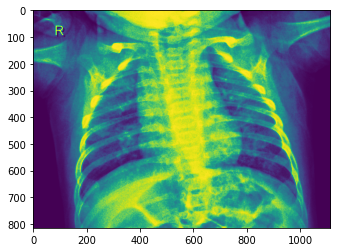

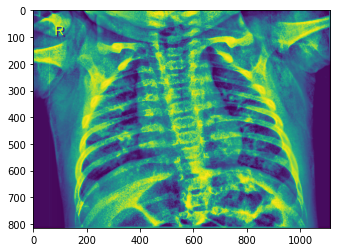

In [4]:
def HistogramEqualization( image, number_bins=256 ):
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum()
    cdf = 255 * cdf / cdf[-1]
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return image_equalized.reshape( image.shape )

def AdaptiveHistogramEqualization( image ):
    image = image / 255.0
    image = skimage.exposure.equalize_adapthist( image, clip_limit=0.03 )
    return image

def normalize( arr ):
    return ( arr - np.min( arr ) ) / ( np.max( arr ) - np.min( arr ) )

im = plt.imread( '../input/deep-learning-competition-cs-2020/train/train/NORMAL/IM-0739-0001.jpeg' )
print( im.shape )
if im.ndim == 3:
    im = skimage.color.rgb2gray( im )
hist = HistogramEqualization( im )
hist2 = AdaptiveHistogramEqualization( im )
plt.imshow( hist );plt.figure();plt.imshow( hist2 );

print( hist.max(), hist2.max() )
print( hist.shape, hist2.shape  )

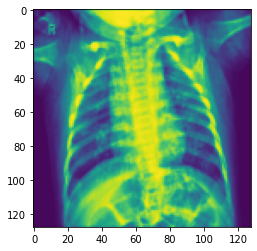

In [5]:
def preprocessing( path, image ):
    image_arr = skimage.io.imread( os.path.join( path, image ) )
    
    if image_arr.ndim == 3:
        image_arr = skimage.color.rgb2gray( im )

    image_arr = HistogramEqualization( image_arr )
    #image_arr = AdaptiveHistogramEqualization( image_arr )
    
    #image_arr = cv2.resize( image_arr, ( image_size, image_size ) )
    image_arr = skimage.transform.resize( image_arr, ( image_size, image_size ), mode='constant', preserve_range=True )
    image_arr = image_arr.reshape( image_size, image_size, 1 )
    image_arr = image_arr / 255.0
    #image_arr = normalize( image_arr )
    return image_arr
ii = preprocessing( '../input/deep-learning-competition-cs-2020/train/train/COVID19 AND PNEUMONIA', 'person1677_bacteria_4443.jpeg' ) 
plt.imshow( ii[:, :, 0] )

In [6]:
def GetTrainData( data_dir, labels = labels ):
    x_data, y_data = [], []
    for label in labels:
        path = os.path.join( data_dir, label )
        class_num = labels.index( label )
        for i, image in tqdm( enumerate( os.listdir( path ) ) ):
            try:
                x_data.append( preprocessing( path, image ) )
                y_data.append( class_num )
            except Exception as e:
                print( e )
    return np.array( x_data ), np.array( y_data )

x_train, y_train = GetTrainData( dir_ + 'train/train/' )

In [7]:
#"""
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(
    x_train, 
    y_train, 
    test_size = 0.10,
    random_state = 42
)
#""";

In [8]:
def GetTestData( data_dir ):
    x_data, names = [], []
    path = os.path.join( data_dir )
    for i, image in tqdm( enumerate( os.listdir( path ) ) ):
        #try:
            names.append( image )
            x_data.append( preprocessing( path, image ) )
        #except Exception as e:
        #    print( e )
    return np.array( x_data ), names

x_test, test_names = GetTestData( dir_ + 'test/test/' )

In [9]:
dfs = tf.io.gfile.glob(
    '../input/*/*.csv'
)

submit = pd.read_csv( dfs[0] )
names = pd.read_csv( dfs[1] )
names

,Name,ID
0,Normal,0
1,COVID19 or Pneumonia,1


In [10]:
print( f"{ x_train.size * x_train.itemsize } bytes" )
print( f"{ x_test.size * x_test.itemsize } bytes" )

621150208 bytes
90439680 bytes


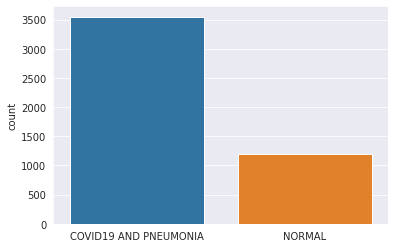

In [11]:
c = []
for i in y_train:
    if( i == 0 ):
        c.append( labels[0] )
    else:
        c.append( labels[1] )
sns.set_style( 'darkgrid' );sns.countplot( c );

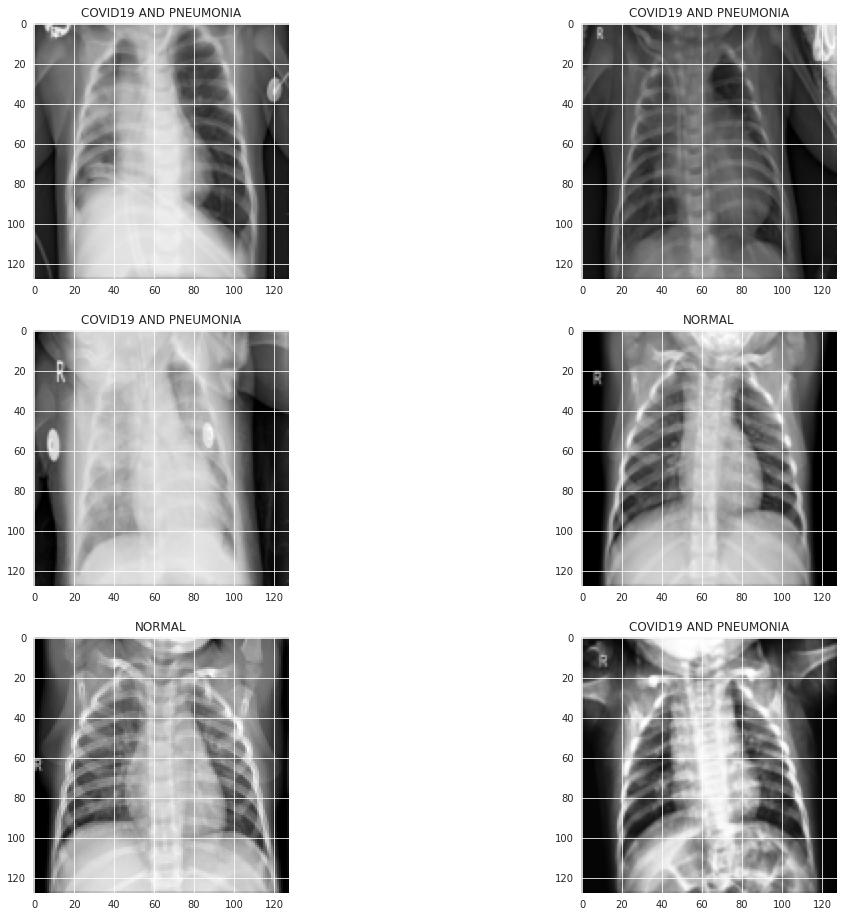

In [12]:
plt.figure( figsize=(18, 16) )
plt.subplot( 321 );plt.imshow( x_train[0].reshape( ( image_size, image_size ) ), cmap='gray' );plt.title( labels[ y_train[0] ] );
plt.subplot( 322 );plt.imshow( x_train[1].reshape( ( image_size, image_size ) ), cmap='gray' );plt.title( labels[ y_train[1] ] );
plt.subplot( 323 );plt.imshow( x_train[2].reshape( ( image_size, image_size ) ), cmap='gray' );plt.title( labels[ y_train[2] ] );
plt.subplot( 324 );plt.imshow( x_train[-3].reshape( ( image_size, image_size ) ), cmap='gray' );plt.title( labels[ y_train[-3] ] );
plt.subplot( 325 );plt.imshow( x_train[-2].reshape( ( image_size, image_size ) ), cmap='gray' );plt.title( labels[ y_train[-2] ] );
plt.subplot( 326 );plt.imshow( x_train[-1].reshape( ( image_size, image_size ) ), cmap='gray' );plt.title( labels[ y_train[-1] ] );

## Data Augmentation :
*     Randomly rotate some training images by 30 degrees
*     Randomly Zoom by 20% some training images
*     Randomly shift images horizontally by 10% of the width
*     Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset.

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
)

datagen.fit( x_train )

In [14]:
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Conv2D( 64 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = ( 128, 128, 1 ) ) )
model.add( tf.keras.layers.Conv2D( 64 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )

model.add( tf.keras.layers.Conv2D( 128 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 128 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )

model.add( tf.keras.layers.Conv2D( 256 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 256 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 256 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 256 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )

model.add( tf.keras.layers.Conv2D( 512 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 512 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 512 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.Conv2D( 512 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )


model.add( tf.keras.layers.Flatten() )
model.add( tf.keras.layers.Dense( units = 4096 , activation = 'relu' ) )
model.add( tf.keras.layers.Dropout( 0.2 ) )

model.add( tf.keras.layers.Dense( units = 4096 , activation = 'relu' ) )
model.add( tf.keras.layers.Dropout( 0.2 ) )

model.add( tf.keras.layers.Dense( units = 1 , activation = 'sigmoid' ) )
model.compile(
    optimizer = tf.keras.optimizers.Adam( 2e-4 ),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       2

In [17]:
#model.load_weights( '../input/covid19weights/weights.h5' )

history = model.fit(
    datagen.flow( x_train, y_train, batch_size = 32 ),
    epochs = 20,
    validation_data = datagen.flow( x_val, y_val ),
)

Train for 149 steps, validate for 17 steps
Epoch 1/20
149/149 [==============================] - 15s 104ms/step - loss: 0.0495 - accuracy: 0.9816 - val_loss: 0.0807 - val_accuracy: 0.9715
Epoch 2/20
149/149 [==============================] - 16s 105ms/step - loss: 0.0462 - accuracy: 0.9827 - val_loss: 0.1232 - val_accuracy: 0.9602
Epoch 3/20
149/149 [==============================] - 15s 104ms/step - loss: 0.0489 - accuracy: 0.9827 - val_loss: 0.0737 - val_accuracy: 0.9715
Epoch 4/20
149/149 [==============================] - 15s 104ms/step - loss: 0.0505 - accuracy: 0.9808 - val_loss: 0.0976 - val_accuracy: 0.9639
Epoch 5/20
149/149 [==============================] - 15s 104ms/step - loss: 0.0514 - accuracy: 0.9791 - val_loss: 0.1021 - val_accuracy: 0.9602
Epoch 6/20
149/149 [==============================] - 16s 106ms/step - loss: 0.0465 - accuracy: 0.9825 - val_loss: 0.0819 - val_accuracy: 0.9734
Epoch 7/20
149/149 [==============================] - 15s 103ms/step - loss: 0.0496 - a

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model

In [ ]:
model = tf.keras.models.Sequential()
model.add( tf.keras.layers.Conv2D( 32 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = ( 128, 128, 1 ) ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )
model.add( tf.keras.layers.Conv2D( 64 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )
model.add( tf.keras.layers.Conv2D( 64 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )
model.add( tf.keras.layers.Conv2D( 128 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )
model.add( tf.keras.layers.Conv2D( 256 , (3, 3) , strides = 1 , padding = 'same' , activation = 'relu' ) )
model.add( tf.keras.layers.MaxPool2D( (2, 2) , strides = 2 , padding = 'same' ) )
model.add( tf.keras.layers.Flatten() )
model.add( tf.keras.layers.Dense( units = 128 , activation = 'relu' ) )
model.add( tf.keras.layers.Dropout( 0.2 ) )
model.add( tf.keras.layers.Dense( units = 1 , activation = 'sigmoid' ) )
model.compile(
    optimizer = tf.keras.optimizers.Adam( 2e-4 ),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True
)

In [ ]:
#model.load_weights( '../input/covid19weights/weights.h5' )

history = model.fit(
    datagen.flow( x_train, y_train, batch_size = 32 ),
    epochs = 200,
    validation_data = datagen.flow( x_val, y_val ),
)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#!rm 'weights.h5'

In [ ]:
model.save_weights( 'weights.h5' )

In [ ]:
h = pd.DataFrame( history.history )
h.plot();

In [18]:
y_test = model.predict(  
    x_test
)

In [19]:
y_test = np.array( y_test )

In [20]:
y_pred = y_test < 0.5
print( y_pred.shape )

(690, 1)


In [21]:
y_pred = y_pred.astype( int ).reshape(1, -1)

In [22]:
y_pred.tolist()[0][1]

1

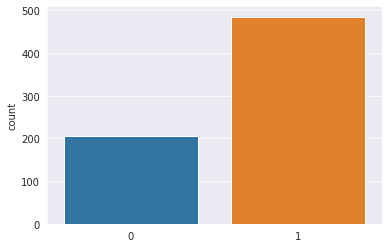

In [25]:
sns.set_style( 'darkgrid' );sns.countplot( y_pred.tolist()[0] );

In [ ]:
!rm 'submit.csv'

In [ ]:
pd.DataFrame({'Image':test_names, 'Label': y_pred[0]})#.to_csv( 'submit.csv', index=False )

In [ ]:
pd.DataFrame({'Image':test_names, 'Label': y_pred[0]}).to_csv( 'submit.csv', index=False )